In [2]:
import json            #fgetting annotation files
import os              #file traversal

In [12]:
#get list of folders
rootDir = '.'
files = os.listdir(rootDir)
for file in files:
    print(os.path.join(rootDir, file))

.\images
.\images_origin
.\labels
.\labels_origin


# Annotation Parsing

## Test with sample data

In [43]:
#data look-over
fileName = '20201102_dog-feetup-000413.mp4'
with open('labels_origin/' + fileName + '.json', 'r', encoding="UTF-8") as lb:
    label = json.load(lb)
    meta = label["metadata"] #type: dict
    anno = label["annotations"] #type: list
    
    print( f'Datatype : {type(label)}\n'
          +f'Main keys: {list(label.keys())}\n'  #video file, data, bounding box
          +f'Metadata : {list(meta.keys())}\n' #needs: action, height, width, (inspect_emotion)
          +f' - action : {meta["action"]}\n'
          +f' - height : {meta["height"]}\n'
          +f' - width  : {meta["width"]}\n'
          +f' - emotion: {meta["inspect"]["emotion"]}\n'
          +f'Frame[0] : {list(anno[0].keys())}\n' #needs: frame_number, timestamp, bounding_box
          +f' - frame number: {anno[0]["frame_number"]}\n'
          +f' - timestamp   : {anno[0]["timestamp"]}\n'
          +f' - bounding box: {anno[0]["bounding_box"]}')

Datatype : <class 'dict'>
Main keys: ['file_video', 'metadata', 'annotations']
Metadata : ['seq', 'species', 'action', 'location', 'height', 'width', 'duration', 'animal', 'owner', 'inspect']
 - action : 두 앞발을 들어 올림
 - height : 1920
 - width  : 1080
 - emotion: 행복/즐거움
Frame[0] : ['frame_number', 'frame_url', 'timestamp', 'keypoints', 'bounding_box']
 - frame number: 0
 - timestamp   : 0
 - bounding box: {'x': 1, 'y': 499, 'width': 1078, 'height': 1227}


In [109]:
#dicts for label indexing
ACTION_DICT = {'머리를 앞으로 들이댐' : 0, #HEAD_FORWARD
               '머리를 앞으로 들이미는 동작' : 0,
               '두 앞발을 들어 올림' : 1, #PAWS_UP
               '두 앞발을 들어 올리는 동작' : 1,
               '앞발 하나를 들어 올림' : 2, #PAW_UP
               '앞발 하나를 들어 올리는 동작' : 2,
               '몸을 턴다' : 3, #SHIVER
               '몸을 터는 동작' : 3,
               '엎드리기(몸체를 낮게 유지)' : 4, #BODY_LOWER
               '엎드리는 동작(몸체를 낮게 유지)' : 4,
               '엎드리는 동작' : 4,
               '배와 목을 보여주며 누움' : 5, #LAY_BACK
               '배와 목을 보여주며 눕는 동작' : 5,
               '꼬리를 위로 올리고 흔듦' : 6, #TAIL_UP
               '꼬리를 위로 올리고 흔드는 동작' : 6,
               '꼬리를 흔듦' : 6,
               '빙글빙글 돈다' : 7, #SPIN
               '빙글빙글 도는 동작' : 7,
               '마운팅' : 8, #MOUNT
               '마운팅하는 동작' : 8,
               '꼬리가 아래로 향함' : 9, #TAIL_DOWN
               '앉기' : 10, #SIT
               '앉는 동작' : 10,
               '몸을 긁음' : 11, #SCRATCH
               '몸을 긁는 동작' : 11,
               '걷거나 뜀' : 12, #MOVE
               '걷거나 뛰는 동작' : 12,
               '걷거나 달리는 동작' : 12}
EMOTION_DICT = {'행복/즐거움' : 0, #HAPPY
                '편안/안정' : 1, #RELAX
                '불안/슬픔' : 2, #ANXIETY
                '화남/불쾌' : 3, #ANGER
                '공포' : 4, #FEAR
                '공격성' : 5} #AGRESSIVE

In [64]:
#generate label information file
#FORM : INDEX X_CENTER Y_CENTER WIDTH HEIGHT (normalized: 0-1)
index, emotion = ACTION_DICT[meta["action"]], EMOTION_DICT[meta["inspect"]["emotion"]]
imgHeight, imgWidth = meta["height"], meta["width"]
FRAME = 5
frame = anno[FRAME]
box = frame["bounding_box"]

#.\labels\20201102_dog-feetup-000413.mp4\frame_0_timestamp_0.txt
#    1 0.5 0.5794270833333334 0.9981481481481481 0.6390625
with open(f'labels/{fileName}/frame_{frame["frame_number"]}_timestamp_{frame["timestamp"]}.txt', 'w') as f:
    x_center = (box['x'] + box['width'] / 2) / imgWidth
    y_center = (box['y'] + box['height'] / 2) / imgHeight
    width = box['width'] / imgWidth
    height = box['height'] / imgHeight
    f.write(f'{index} {x_center} {y_center} {width} {height}\n')

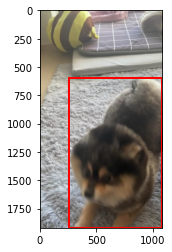

In [65]:
#check bounding box adequacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#get image
im = Image.open(f'images_origin/{fileName}/frame_{frame["frame_number"]}_timestamp_{frame["timestamp"]}.jpg')
plt.imshow(im)

ax = plt.gca() #get axes handle

#draw bounding box
rect = patches.Rectangle((x_center * imgWidth - box['width'] / 2 , y_center * imgHeight - box['height'] / 2),
                 width * imgWidth,
                 height * imgHeight,
                 linewidth=2,
                 edgecolor='red',
                 fill = False)
ax.add_patch(rect)

#display
plt.show()

## Manipulating full data

In [114]:
#get json file list
annoList = os.listdir('./labels_origin')

for annoFile in annoList:
    #get essential data
    with open(f'labels_origin/{annoFile}', 'r', encoding='UTF-8') as lb:
        label = json.load(lb)
        meta = label["metadata"]
        anno = label["annotations"]
    index = ACTION_DICT[meta["action"]]
    imgHeight, imgWidth = meta["height"], meta["width"]
    
    for f in range(len(anno)):
        frame = anno[f]
        box = frame["bounding_box"]
        
        x_center = (box['x'] + box['width'] / 2) / imgWidth
        y_center = (box['y'] + box['height'] / 2) / imgHeight
        width = box['width'] / imgWidth
        height = box['height'] / imgHeight
        
        #write new label file
        #000019_frame_0_timestamp_0.txt
        with open(f'labels/{annoFile.rstrip(".json").rstrip(".mp4")[-6:]}_frame_{frame["frame_number"]}_timestamp_{frame["timestamp"]}.txt', 'w') as f:
            f.write(f'{index} {x_center} {y_center} {width} {height}\n')

# Formatting

## Extracting Images

In [113]:
import shutil

root = './images_origin'

imgList = os.listdir(root)
for dr in imgList:
    for file in os.listdir(f'{root}/{dr}'):
        shutil.copyfile(f'{root}/{dr}/{file}', f'./images/{dr.rstrip(".mp4")[-6:]}_{file}')

## Move random 10% images to test folder

In [117]:
import random

imgList = os.listdir('./train/images')
random.shuffle(imgList)
for i in range(len(imgList) // 10):
    name = imgList[i].rstrip("jpg")
    shutil.move(f'./train/images/{name}jpg', f'./test/images/{name}jpg')
    shutil.move(f'./train/labels/{name}txt', f'./test/labels/{name}txt')

In [14]:
import shutil
import random

imgList = os.listdir('./train4/images')
random.shuffle(imgList)
for i in range(len(imgList) // 2):
    name = imgList[i].rstrip("jpg")
    shutil.move(f'./train4/images/{name}jpg', f'./train8/images/{name}jpg')
    shutil.move(f'./train4/labels/{name}txt', f'./train8/labels/{name}txt')

In [6]:
%cd Petrain

C:\Users\Suin\Python\Pytorch_dl\data\Petrain


# Training

In [118]:
#cd Python\Pytorch_dl\yolov5
#!python train.py --img 1727 --batch 6 --epochs 50 --data Petrain.yaml --weights runs\